# [Digit Recognizer](https://www.kaggle.com/c/digit-recognizer)

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Let's see if we can create a classifier that scores at least a 99% accuracy. For this task, we'll use the fastai MNIST dataset

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from PIL import Image
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from sklearn.model_selection import train_test_split

In [4]:
path = Path('./data/')
df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
path.ls(), df.shape, test_df.shape

([PosixPath('data/submission.csv'),
  PosixPath('data/test.csv'),
  PosixPath('data/train.csv'),
  PosixPath('data/sample_submission.csv')],
 (42000, 785),
 (28000, 784))

## Put data into a databunch

### Grab images & labels
We'll also reshape them to be of size (batch_size, 3-channels, 28px, 28px)

In [5]:
labels = df['label'].values
images = df[[c for c in df.columns if c != 'label']].values
images = images.reshape(-1, 1, 28, 28).repeat(3, 1)

test_images = test_df.values.reshape(-1, 1, 28, 28).repeat(3,1)

labels.shape, images.shape, test_images.shape

((42000,), (42000, 3, 28, 28), (28000, 3, 28, 28))

### Normalize images
The image mean should be ~0 and std ~1.0

In [6]:
images_mean = images.mean()
images_std = images.std()

def normalize(imgs): 
    return (imgs - images_mean) / images_std

images = normalize(images)
test_images = normalize(test_images)

print('Label shape: ', labels.shape)
print('Images shape: ', images.shape)
print('Test Images shape: ', test_images.shape)
print('Images mean: {:4f} std: {:4f}'.format(images.mean(), images.std()))
print('Test Images mean: {:4f} std: {:4f}'.format(test_images.mean(), test_images.std()))

Label shape:  (42000,)
Images shape:  (42000, 3, 28, 28)
Test Images shape:  (28000, 3, 28, 28)
Images mean: 0.000000 std: 1.000000
Test Images mean: -0.000729 std: 0.999257


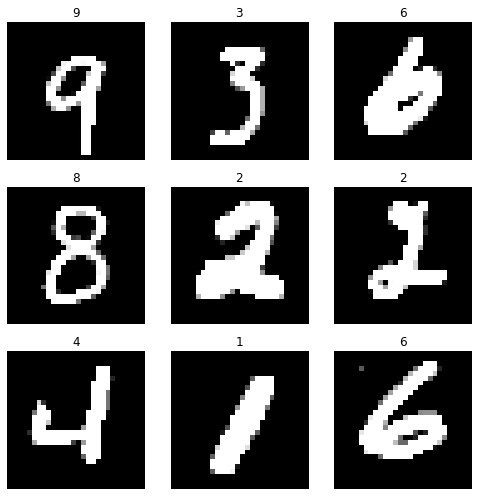

In [7]:
class ArrayImageList(ImageList):
    @classmethod
    def from_numpy(cls, numpy_array):
        return cls(items=range(len(numpy_array)), inner_df=numpy_array)
    
    def label_from_array(self, array, label_cls=None, **kwargs):
        return self._label_from_list(array[self.items.astype(np.int)],label_cls=label_cls,**kwargs)
    
    def get(self, i):
        n = self.inner_df[i]
        n = torch.tensor(n).float()
        return Image(n)

data = (ArrayImageList.from_numpy(images)
        .split_subsets(train_size=0.8, valid_size=0.2)
        .label_from_array(np.int_(labels))
        .add_test(ArrayImageList.from_numpy(test_images))
        .databunch(bs=1024))

data.show_batch(rows=3, figsize=(7,7))

In [8]:
learner = cnn_learner(data, models.resnet152, metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


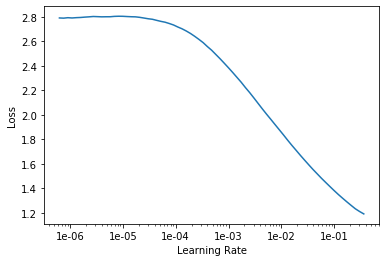

In [9]:
learner.lr_find()
learner.recorder.plot()

In [10]:
learner.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.777813,0.530669,0.847143,00:23
1,0.325610,0.075222,0.977500,00:22
2,0.164203,0.069002,0.979167,00:22
3,0.086723,0.046901,0.985952,00:22
4,0.046488,0.046062,0.987024,00:22


In [11]:
learner.save('stage-1')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


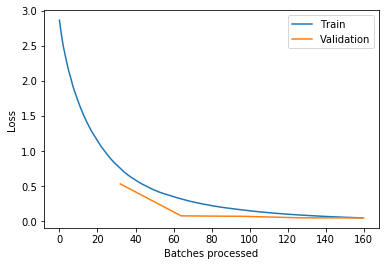

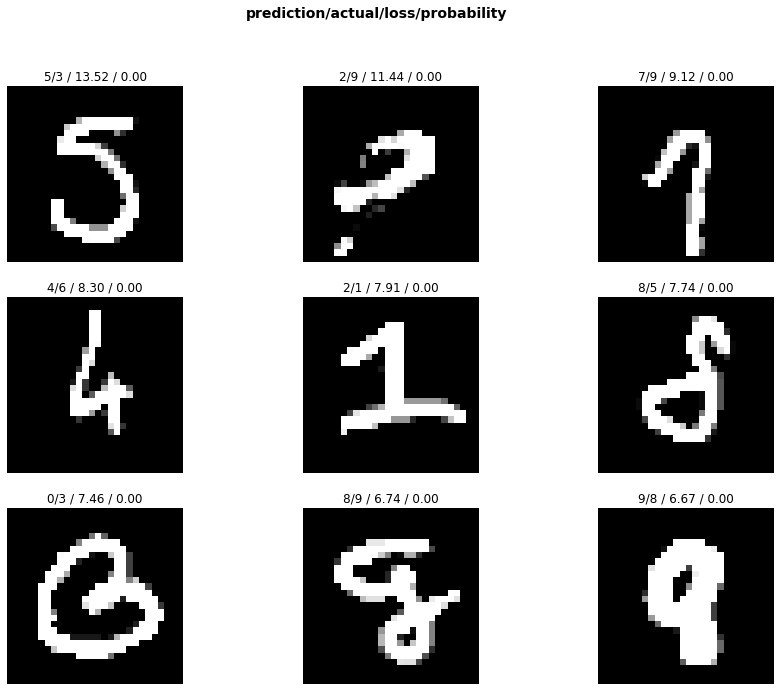

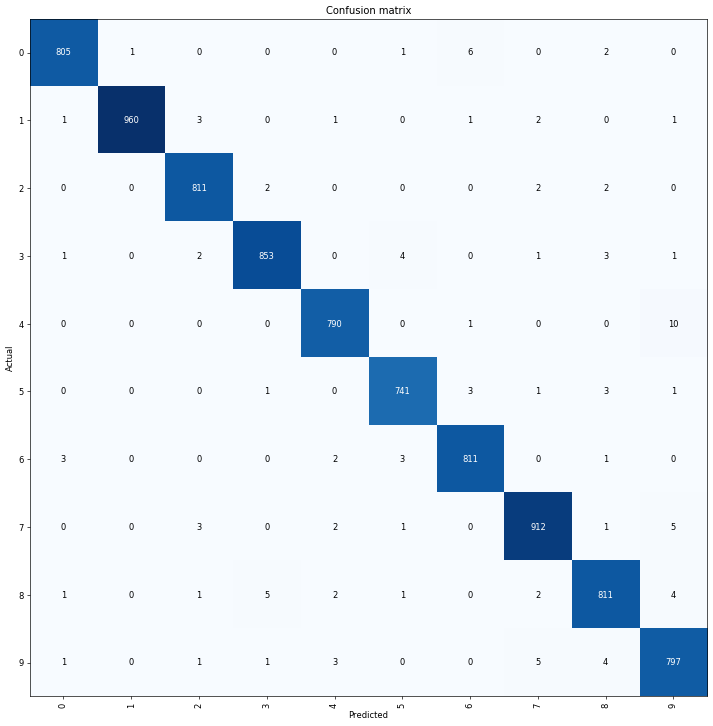

In [12]:
def interp_learner(learner):
    interp = ClassificationInterpretation.from_learner(learner)
    losses,idxs = interp.top_losses()
    learner.recorder.plot_losses()
    interp.plot_top_losses(9, figsize=(15,11))
    interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
    interp.most_confused(min_val=2)

interp_learner(learner)

## Unfreeze and train all layers

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


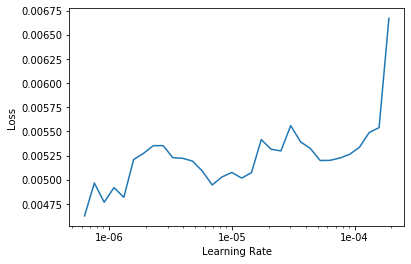

In [13]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [14]:
learner.load('stage-1')
learner.unfreeze()
learner.fit_one_cycle(5, slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.004809,0.045322,0.986548,00:27
1,0.004125,0.043763,0.987738,00:27
2,0.003228,0.043702,0.987619,00:27
3,0.002516,0.043631,0.987619,00:28
4,0.002169,0.043427,0.987976,00:28


In [ ]:
interp_learner(learner)

In [ ]:
learner.save('stage-2')

## Create Predictions

In [ ]:
preds = learner.get_preds(ds_type=DatasetType.Test)
preds

In [ ]:
final_preds = [np.argmax(p).item() for p in preds[0]]
final_preds[:5], np.unique(final_preds)

In [ ]:
sub = pd.DataFrame({'ImageId': range(1, len(final_preds)+1), 'Label': final_preds})
sub.head()

In [ ]:
sub.to_csv(path/'submission.csv', index=False)